#  <center> Speech Emotion Recognition <center>

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [ ]:
# Standard Library
import os
import sys
from pathlib import Path
import warnings

# Suppress Warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Numerical & Data Handling
import numpy as np
import pandas as pd

# Audio Processing
import librosa
import librosa.display
from IPython.display import Audio
import kagglehub  # for downloading datasets

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit‑learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

# Transformers & PEFT (QLoRA)
from transformers import WhisperProcessor, WhisperModel, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType


# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ravdess_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
ravdess_path += "/audio_speech_actors_01-24/"

print("Path to dataset files:", ravdess_path)

Path to dataset files: /kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/


In [ ]:
crema_path = kagglehub.dataset_download("ejlok1/cremad")
crema_path += "/AudioWAV/"

print("Path to dataset files:", crema_path)

Path to dataset files: /kaggle/input/cremad/AudioWAV/


In [ ]:
tess_path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
tess_path += "/TESS Toronto emotional speech set data/"

print("Path to dataset files:", tess_path)

Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/


In [ ]:
savee_path = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
savee_path += "/ALL/"

print("Path to dataset files:", savee_path)

Path to dataset files: /kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/


# Data Preperation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [ ]:
ravdess_directory_list = os.listdir(ravdess_path)

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    dir_path = os.path.join(ravdess_path, dir)

    if os.path.isdir(dir_path):  # Check if it's a directory
        actor_files = os.listdir(dir_path)
        for file in actor_files:
            part = file.split('.')[0]
            part = part.split('-')
            file_emotion.append(int(part[2]))
            file_path.append(os.path.join(dir_path, file))

# Create dataframes
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Replace emotion codes with labels
Ravdess_df.Emotions.replace({
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}, inplace=True)

Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

## <center>2. Crema-D DataFrame</center>

In [ ]:
crema_directory_list = os.listdir(crema_path)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(crema_path + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  disgust  /kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
1    happy  /kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
2    happy  /kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
3  disgust  /kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
4  disgust  /kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav

##  <center> 3. TESS dataset <center>

In [ ]:
tess_directory_list = os.listdir(tess_path)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess_path + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess_path + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

##  <center> 4. Savee dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [ ]:
savee_directory_list = os.listdir(savee_path)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(savee_path + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
1     fear  /kaggle/input/surrey-audiovisual-expressed-emo...
2    happy  /kaggle/input/surrey-audiovisual-expressed-emo...
3  disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
4    angry  /kaggle/input/surrey-audiovisual-expressed-emo...

##Combine Datasets

In [ ]:
os.makedirs('/content/drive/MyDrive/SER', exist_ok=True)

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("/content/drive/MyDrive/SER/data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/a...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/a...

# Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

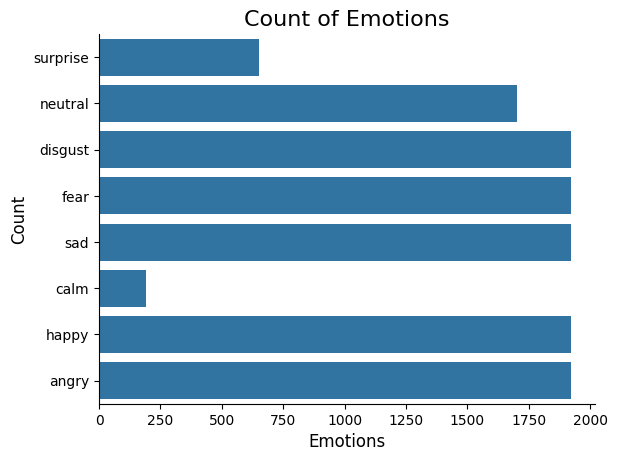

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [ ]:
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

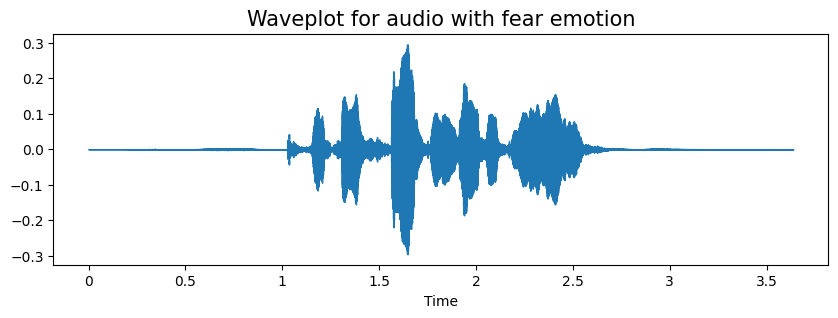

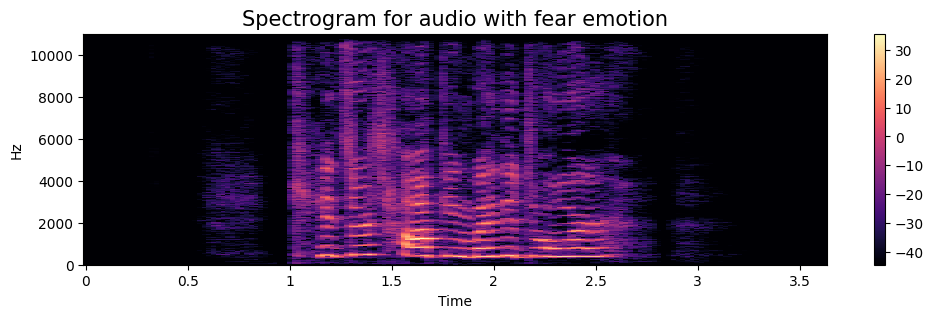

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

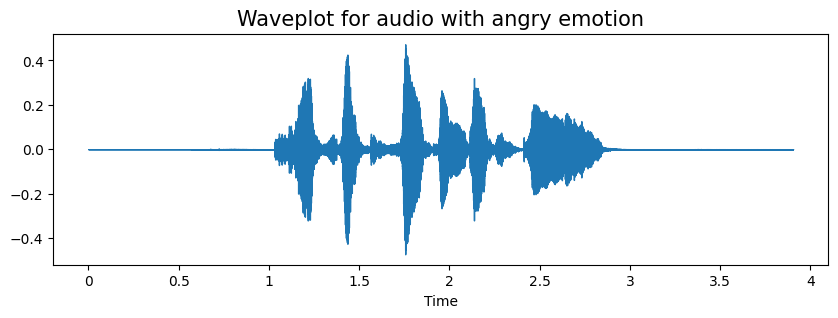

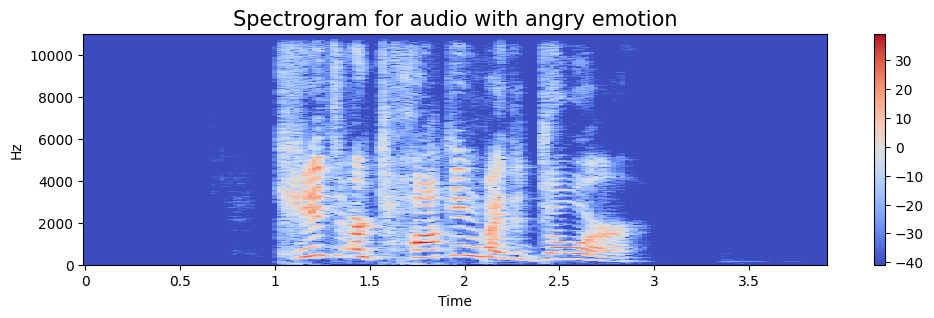

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

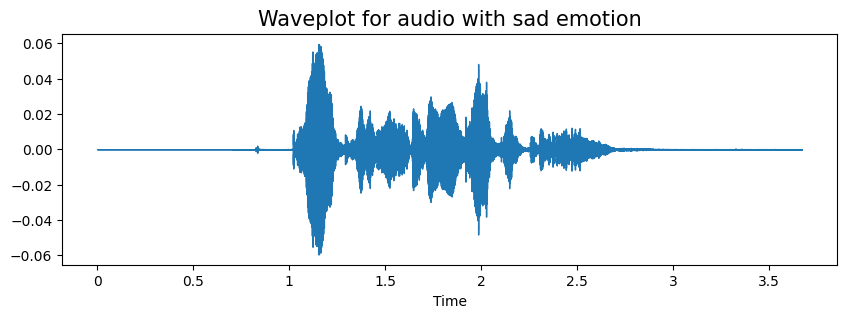

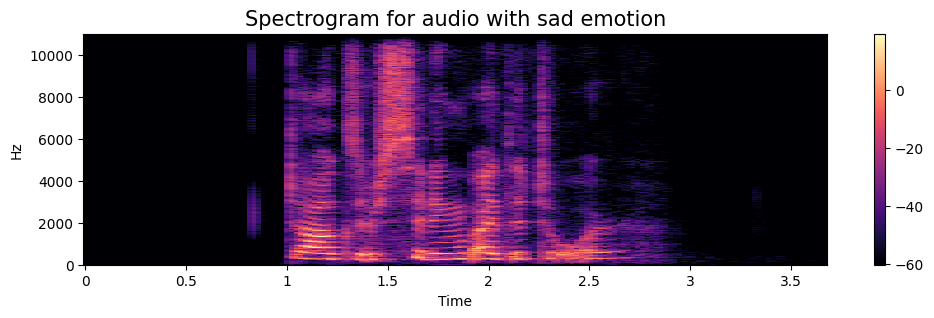

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

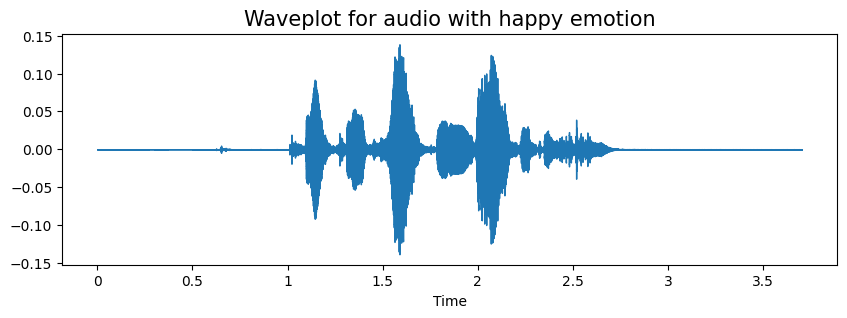

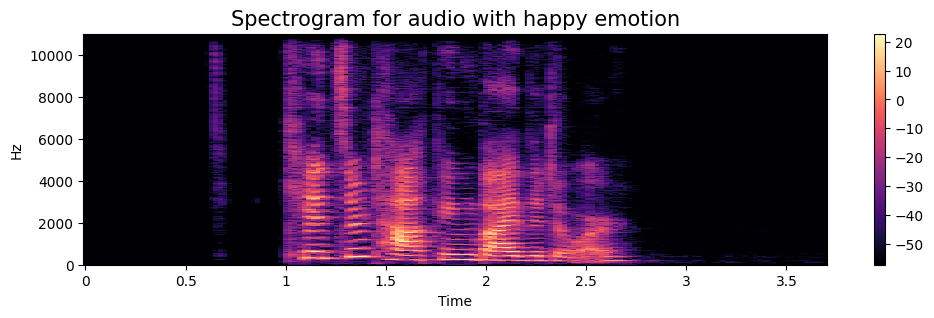

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

- Data augmentation is the process of creating new synthetic data samples by adding small perturbations to the original training set.
- For audio data, we can apply techniques such as noise injection, time shifting, pitch shifting, and speed changes.
- The goal is to make the model invariant to these perturbations and improve its ability to generalize.

- For augmentation to be effective, the perturbed samples must retain the same label as the original training samples.
- In image data, augmentation can include shifting, zooming, and rotating the image, among other transformations.

First, let's check which augmentation techniques works better for our dataset.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

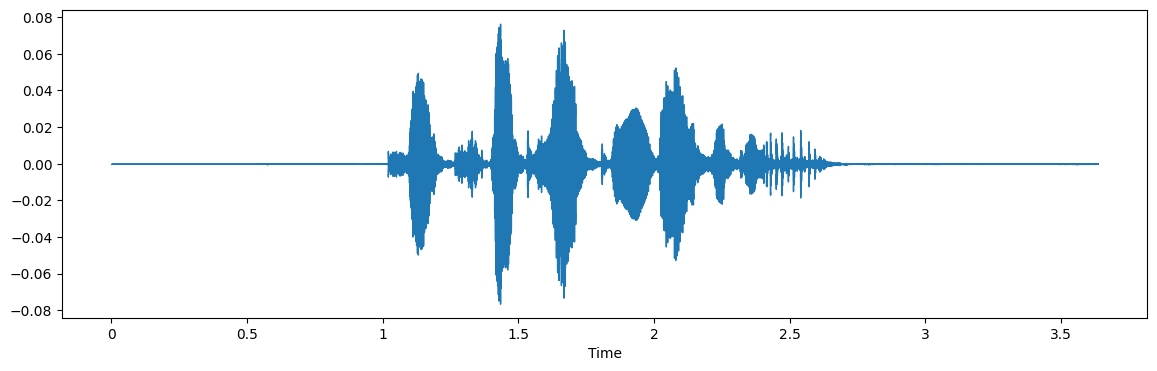

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

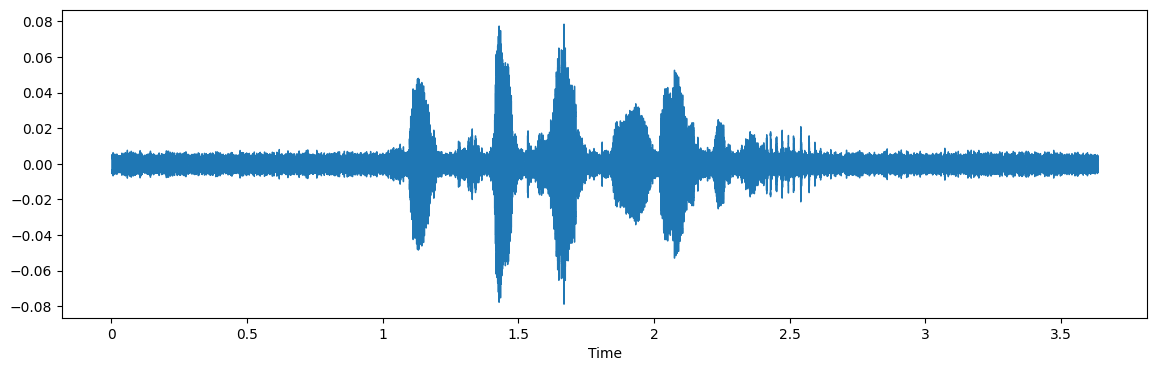

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

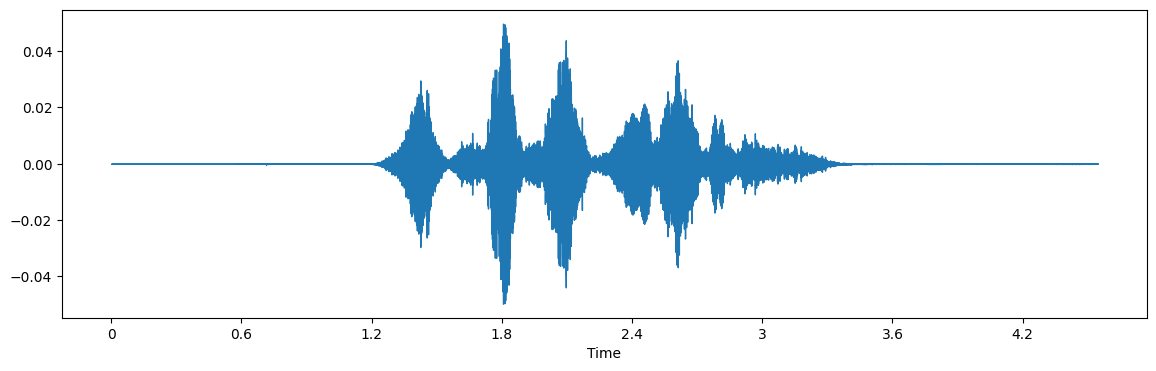

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

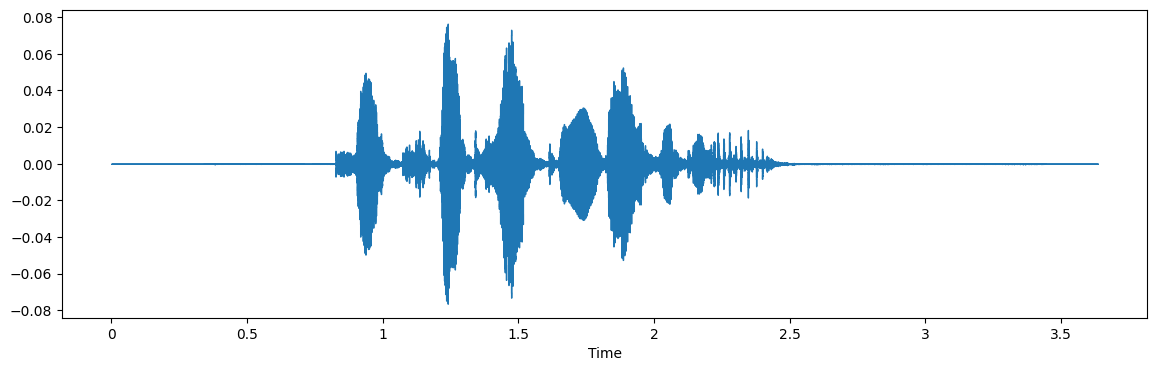

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

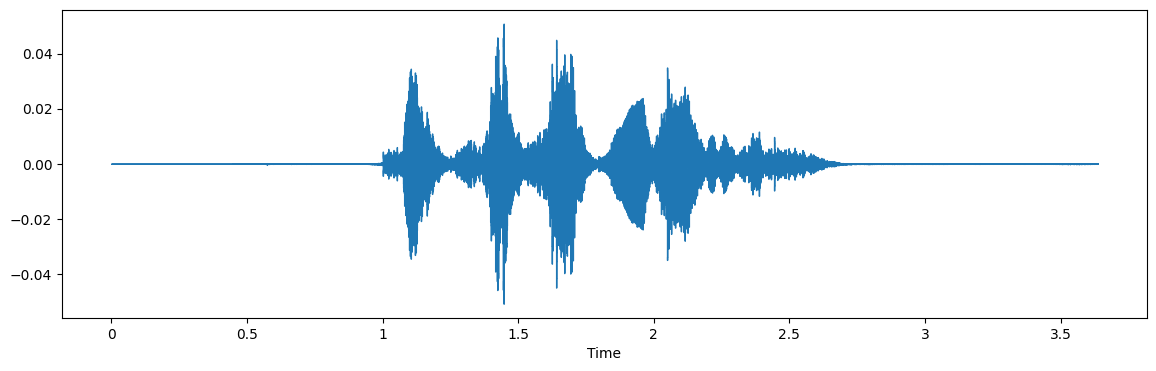

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

In [ ]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of numpy-minmax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of numpy-rms to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: librosa
    Found existing installation: librosa 0.11.0
    Uninstalling librosa-0.11.0:
      Successfully uninstalled librosa-0.11.

In [ ]:
import os
import shutil
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
import soundfile as sf
from tqdm import tqdm
from audiomentations import (
    Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
)
import numpy as np

#  ─── GLOBAL CONFIG ────────────────────────────────────────────────────────
DRIVE_CSV     = Path("/content/drive/MyDrive/SER/data_path.csv")
DRIVE_OUT_CSV = Path("/content/drive/MyDrive/SER/data_path_with_augmentations.csv")
DRIVE_AUG_DIR = Path("/content/drive/MyDrive/SER/augmented_data")

LOCAL_ROOT    = Path("/tmp/SER_data")
LOCAL_AUG_DIR = Path("/tmp/SER_augmented")

# Define once at module-level so it’s picklable
augmenters = {
    "noise":   Compose([AddGaussianNoise(min_amplitude=0.001,  max_amplitude=0.015, p=1.0)]),
    "stretch": Compose([TimeStretch(min_rate=0.8, max_rate=0.8, p=1.0)]),
    "shift":   Compose([Shift(min_shift=-0.5, max_shift=0.5, shift_unit="fraction", p=1.0)]),
    "pitch":   Compose([PitchShift(min_semitones=4, max_semitones=4, p=1.0)]),
}

def process_file(pair):
    """Load one file, apply all augmentations, write out results."""
    local_path, label = pair
    try:
        y, sr = sf.read(local_path)  # y shape: (samples,) or (samples, channels)
    except Exception as e:
        print(f"[ERROR] reading {local_path}: {e}")
        return []

    # Handle mono vs multichannel
    if y.ndim == 1:
        y_proc = y[np.newaxis, :]  # (1, samples)
        mono = True
    else:
        y_proc = y.T                # (channels, samples)
        mono = False

    stem, ext = Path(local_path).stem, Path(local_path).suffix
    results = []

    for name, aug in augmenters.items():
        out_fname = f"{stem}_{name}{ext}"
        out_path  = LOCAL_AUG_DIR / out_fname

        # ── skip if already there ───────────────────────────────
        if out_path.exists():
            results.append((out_path, label))
            continue
        # ─────────────────────────────────────────────────────────

        try:
            y_aug = aug(samples=y_proc, sample_rate=sr)
            y_out = y_aug.flatten() if mono else y_aug.T
            sf.write(out_path, y_out, sr)
            results.append((out_path, label))
        except Exception as e:
            print(f"[ERROR] augment {name} on {local_path}: {e}")

    return results


def augmentation_process():
    # 1) Load CSV
    df = pd.read_csv(DRIVE_CSV)

    # 2) Copy originals into /tmp
    LOCAL_ROOT.mkdir(parents=True, exist_ok=True)
    for src_path in tqdm(df["Path"].unique(), desc="Copying originals"):
        src = Path(src_path)
        dst = LOCAL_ROOT / src.name
        if not dst.exists():
            shutil.copy(src, dst)
    df["local_path"] = df["Path"].apply(lambda p: str(LOCAL_ROOT / Path(p).name))

    # 3) Prepare output dir
    LOCAL_AUG_DIR.mkdir(parents=True, exist_ok=True)

        # 4) Parallel augment with progress bar, skipping fully-augmented files
    all_pairs = list(zip(df["local_path"], df["Emotions"]))
    names = list(augmenters.keys())
    to_process = []
    results = []
    # Pre-fill results with existing augmentations
    for local_path, label in all_pairs:
        stem = Path(local_path).stem
        ext  = Path(local_path).suffix
        # check each augmentation
        missing = False
        for name in names:
            out_path = LOCAL_AUG_DIR / f"{stem}_{name}{ext}"
            if out_path.exists():
                results.append((out_path, label))
            else:
                missing = True
        if missing:
            to_process.append((local_path, label))

    # Process only files with missing augmentations
    if to_process:
        with ProcessPoolExecutor(max_workers=os.cpu_count()) as executor:
            for out in tqdm(executor.map(process_file, to_process, chunksize=4),
                            total=len(to_process), desc="Augmenting"):
                results.extend(out)
    else:
        tqdm.write("All files already fully augmented, skipping processing.")

    # 5) Build augmented DataFrame
    if results:
        aug_paths, aug_labels = zip(*results)
    else:
        aug_paths, aug_labels = [], []
    drive_paths = [str(DRIVE_AUG_DIR / p.name) for p in aug_paths]
    aug_df = pd.DataFrame({"Emotions": aug_labels, "Path": drive_paths})
    if results:
        aug_paths, aug_labels = zip(*results)
    else:
        aug_paths, aug_labels = [], []
    drive_paths = [str(DRIVE_AUG_DIR / p.name) for p in aug_paths]
    aug_df = pd.DataFrame({"Emotions": aug_labels, "Path": drive_paths})

        # 6) Concat original + augmented, shuffle
    full_df = pd.concat([df[["Emotions","Path"]], aug_df], ignore_index=True)
    full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # 7) Save CSV locally and copy to Drive with progress bar
    local_out = Path("/tmp/data_path_with_augmentations.csv")
    tqdm.write("Saving CSV to local and copying to Drive...")
    full_df.to_csv(local_out, index=False)
    # Ensure parent exists
    DRIVE_OUT_CSV.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy(local_out, DRIVE_OUT_CSV)

    # 8) Rsync augmented files back to Drive with error handling and tqdm
    if DRIVE_AUG_DIR.exists():
        shutil.rmtree(DRIVE_AUG_DIR)
    DRIVE_AUG_DIR.mkdir(parents=True, exist_ok=True)
    aug_files = list(LOCAL_AUG_DIR.rglob("*"))
    for src_file in tqdm(aug_files, desc="Syncing augmented files"):
        rel_path = src_file.relative_to(LOCAL_AUG_DIR)
        dest_file = DRIVE_AUG_DIR / rel_path
        dest_file.parent.mkdir(parents=True, exist_ok=True)
        try:
            shutil.copy(src_file, dest_file)
        except Exception as e:
            tqdm.write(f"[ERROR] copying {src_file.name}: {e}")

    # 9) Report
    print(f"Original samples: {len(df)}")
    print(f"Augmented samples: {len(aug_df)}")
    print(f"Total samples now:  {len(full_df)}")





if __name__ == "__main__":
    augmentation_process()


Augmenting: 100%|██████████| 12162/12162 [08:46<00:00, 23.09it/s]


Saving CSV to local and copying to Drive...


Syncing augmented files: 100%|██████████| 48648/48648 [09:48<00:00, 82.64it/s] 

Original samples: 12162
Augmented samples: 48648
Total samples now:  60810


In [ ]:
tqdm.pandas(desc="Checking files")

# Path to your CSV
csv_path = "/content/drive/MyDrive/SER/data_path_with_augmentations.csv"

# Load the CSV
df = pd.read_csv(csv_path)

# Use progress_apply to show a tqdm bar while checking each file
exists_mask = df["Path"].progress_apply(os.path.exists)

# Filter out missing files
filtered_df = df[exists_mask].reset_index(drop=True)

# Report how many you dropped
dropped = len(df) - len(filtered_df)
print(f"Dropped {dropped} rows pointing to missing files.")

# Overwrite the original CSV with only existing-path rows
filtered_df.to_csv(csv_path, index=False)

Checking files: 100%|██████████| 60810/60810 [00:28<00:00, 2153.92it/s]


Dropped 0 rows pointing to missing files.


# Dataset Setup

In [ ]:
emotion2label = {
    'neutral': 0,
    'calm': 1,
    'happy': 2,
    'sad': 3,
    'angry': 4,
    'fear': 5,
    'disgust': 6,
    'surprise': 7
}

In [ ]:
class SERDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, processor, target_sr=16000):
        self.dataframe = dataframe.copy()
        self.processor = processor
        self.target_sr = target_sr
        self.emotion2label = emotion2label

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio, sr = librosa.load(row['Path'], sr=self.target_sr)
        inputs = self.processor(audio,
                                 sampling_rate=self.target_sr,
                                 return_tensors="pt")
        features = inputs.input_features[0]       # (feat_len, n_mels)
        label = self.emotion2label[row['Emotions'].strip().lower()]
        return {"input_values": features, "labels": label}

#FineTuning Whisper

##Finetuning using LoRA

In [ ]:
DATA_CSV     = "/content/drive/MyDrive/SER/data_path_with_augmentations.csv"
CHECKPOINTS  = "/content/drive/MyDrive/SER/checkpoints"
PRETRAINED   = "openai/whisper-base"
BATCH_SIZE   = 16                         # reduced from 16 to fit GPU memory
LR           = 1e-4
EPOCHS       = 15
TARGET_SR    = 16000
RANDOM_STATE = 42

os.makedirs(CHECKPOINTS, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class WhisperSERModel(nn.Module):
    def __init__(self, encoder, num_labels):
        super(WhisperSERModel, self).__init__()
        self.encoder = encoder
        self.config = encoder.config  # Needed for PEFT
        self.dropout = nn.Dropout(0.1)
        hidden_size = encoder.config.d_model
        self.fc = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids=None, input_values=None, **kwargs):

        if input_ids is None and input_values is not None:
            input_ids = input_values
        if input_ids is None:
            raise ValueError("You must provide either input_ids or input_values.")

        encoder_outputs = self.encoder(input_ids, output_hidden_states=True)
        hidden_states = encoder_outputs.last_hidden_state  # shape: (batch, seq_len, hidden_size)
        pooled = hidden_states.mean(dim=1)
        pooled = self.dropout(pooled)
        logits = self.fc(pooled)
        return logits


In [ ]:
processor = WhisperProcessor.from_pretrained(PRETRAINED)
whisper_full = WhisperModel.from_pretrained(PRETRAINED)
whisper_encoder = whisper_full.encoder

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

In [ ]:
num_labels = len(emotion2label)
model = WhisperSERModel(whisper_encoder, num_labels)

In [ ]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Use SEQ_CLS for sequence classification
    r=4,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "out_proj",
        "encoder.embed_positions",
        "fc1",
        "fc2",
    ],
    inference_mode=False,
)

model = get_peft_model(model, lora_config)

print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Trainable parameters: 229232


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.encoder.embed_positions.lora_embedding_A.default
base_model.model.encoder.embed_positions.lora_embedding_B.default
base_model.model.encoder.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.encoder.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.encoder.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.encoder.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.encoder.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.encoder.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.encoder.layers.0.self_attn.out_proj.lora_A.default.weight
base_model.model.encoder.layers.0.self_attn.out_proj.lora_B.default.weight
base_model.model.encoder.layers.0.fc1.lora_A.default.weight
base_model.model.encoder.layers.0.fc1.lora_B.default.weight
base_model.model.encoder.layers.0.fc2.lora_A.default.weight
base_model.model.encoder.layers.0.fc2.lora_B.default.weight
base_model.model.encoder.layers.1.self_a

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split

# 1. fix the seed
torch.manual_seed(0)

# 2. load your data and wrap in a Dataset
data = pd.read_csv(DATA_CSV)
dataset = SERDataset(data, processor, target_sr=16000)

# 3. compute sizes
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size

# 4. do the split
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size],generator=torch.Generator().manual_seed(RANDOM_STATE))

# 5. DataLoaders
def collate_fn(batch):
    return {
        "input_values": torch.nn.utils.rnn.pad_sequence(
            [item["input_values"] for item in batch],
            batch_first=True
        ),
        "labels": torch.tensor([item["labels"] for item in batch], dtype=torch.long)
    }

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    collate_fn=collate_fn, num_workers=4
)
test_loader = DataLoader(
    test_dataset,  batch_size=BATCH_SIZE, shuffle=False,
    collate_fn=collate_fn, num_workers=4
)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()


In [ ]:
model.to(device)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): WhisperSERModel(
      (encoder): WhisperEncoder(
        (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
        (embed_positions): lora.Embedding(
          (base_layer): Embedding(1500, 512)
          (lora_dropout): ModuleDict(
            (default): Dropout(p=0.1, inplace=False)
          )
          (lora_A): ModuleDict()
          (lora_B): ModuleDict()
          (lora_embedding_A): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 4x1500 (cuda:0)])
          (lora_embedding_B): ParameterDict(  (default): Parameter containing: [torch.cuda.FloatTensor of size 512x4 (cuda:0)])
          (lora_magnitude_vector): ModuleDict()
        )
        (layers): ModuleList(
          (0-5): 6 x WhisperEncoderLayer(
            (self_attn): WhisperSdpaAttention(
              (k_proj): lo

In [ ]:
ckpts = sorted(os.listdir(CHECKPOINTS))
start_epoch = 0
if ckpts:
    latest = ckpts[-1]
    path   = os.path.join(CHECKPOINTS, latest)
    print(f"Resuming from {path}")
    ckpt   = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    start_epoch = ckpt["epoch"] + 1


# ---------------------- training loop ---------------------- #
for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)

    for batch in pbar:
        inputs = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_values=inputs)
        loss   = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} train loss: {avg_loss:.4f}")

    # save checkpoint
    ckpt = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "loss": avg_loss
    }
    ckpt_path = os.path.join(CHECKPOINTS, f"ckpt_epoch{epoch+1:02d}.pt")
    torch.save(ckpt, ckpt_path)
    print(f"Saved {ckpt_path}")

Epoch 1 train loss: 0.9866
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch01.pt


Epoch 2 train loss: 0.5768
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch02.pt


Epoch 3 train loss: 0.4489
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch03.pt


Epoch 4 train loss: 0.3625
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch04.pt


Epoch 5 train loss: 0.2939
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch05.pt


Epoch 6 train loss: 0.2345
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch06.pt


Epoch 7 train loss: 0.1871
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch07.pt


Epoch 8 train loss: 0.1510
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch08.pt


Epoch 9 train loss: 0.1224
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch09.pt


Epoch 10 train loss: 0.1021
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch10.pt


Epoch 11 train loss: 0.0873
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch11.pt


Epoch 12 train loss: 0.0783
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch12.pt


Epoch 13 train loss: 0.0676
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch13.pt


Epoch 14 train loss: 0.0632
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch14.pt


Epoch 15 train loss: 0.0555
Saved /content/drive/MyDrive/SER/checkpoints/ckpt_epoch15.pt


In [ ]:
import threading, time, os
from IPython import get_ipython

def shutdown_after_idle(timeout_seconds=30*60):
    last_run = time.time()

    # bump last_run whenever you execute any cell
    def pre_run_hook():
        nonlocal last_run
        last_run = time.time()
    ip = get_ipython()
    ip.events.register('pre_run_cell', pre_run_hook)

    # background monitor thread
    def monitor():
        while True:
            if time.time() - last_run > timeout_seconds:
                print(f"No cells executed in {timeout_seconds//60} min—shutting down.")
                os._exit(0)
            time.sleep(10)
    t = threading.Thread(target=monitor, daemon=True)
    t.start()

# —— EDIT THIS: timeout in seconds (e.g. 1800 = 30 min) ——
shutdown_after_idle(timeout_seconds=5*60)


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    test_progress = tqdm(test_loader, desc="Testing", leave=False)
    for batch in test_progress:
        inputs = batch["input_values"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_values=inputs)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_accuracy = accuracy_score(all_labels, all_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

print("Test Metrics:")
print(f"  Accuracy : {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall   : {test_recall:.4f}")
print(f"  F1 Score : {test_f1:.4f}")

Test Metrics:
  Accuracy : 0.8698
  Precision: 0.8714
  Recall   : 0.8698
  F1 Score : 0.8693


In [ ]:
# Directory where you want to save your fine‑tuned model
OUTPUT_DIR = "/content/drive/MyDrive/SER/fine_tuned_whisper-base"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Save the PEFT‐wrapped model (this writes out only the LoRA adapters + config)
model.save_pretrained(OUTPUT_DIR)

# 2. Save the processor (feature extractor + tokenizer)
processor.save_pretrained(OUTPUT_DIR)

print(f"Saved fine‑tuned model and processor to {OUTPUT_DIR}")

Saved fine‑tuned model and processor to /content/drive/MyDrive/SER/fine_tuned_whisper-base
